<div class="head0">
    <div class="head0__name">
        Diffusion equation with linear drift in 3D case
    </div>
    <div class="head0__note">
        Solution of the 3D Fokker-Planck equation with linear drift (multivariate Ornstein–Uhlenbeck process) by fast and accurate tensor based method.
    </div>
</div>

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt

sys.path.extend(['./../lib', './../helpers'])
from solver import Solver as Solver
from helpers import init_jupyter; init_jupyter()

Start |  2:53PM MSK on Sep 05, 2019 |
-------------------------------------


<div class="head1">
    <div class="head1__name">
        Model problem
    </div>
</div>

Consider SDE
$$
    dx = f(x, t) \, dt + S(x, t) \, d\beta,
    \quad
    d\beta \, d\beta^{\top} = Q(t) dt,
    \quad
    x(0) = x_0 \sim \rho(x, 0) = \rho_0 (x),
$$
where spatial $d$-dimensional ($d \ge 1$) variable $x \in R^d$ has probability density function (PDF) $\rho(x, t)$, $\beta$ is Brownian motion of dimension $q$ ($q \ge 1$, and we assume below that $q = d$), $f(x, t) \in R^d$ is a vector-function and $S(x, t) \in R^{d \times q}$ is a matrix-function.

It can be shown that the PDF $\rho(x, t)$ at time $t$ ($t > 0$) is the solution of the Fokker-Planck equation
$$
    \frac{\partial \rho(x, t)}{\partial t} =
        - \sum_{i=1}^d
            \frac{\partial}{\partial x_i}
            \left[ f_i(x, t) \rho(x, t) \right]
        + \sum_{i=1}^d \sum_{j=1}^d
            \frac{\partial^2}{\partial x_i \partial x_j}
            \left[ D_{ij}(x, t) \rho(x, t) \right],
    \quad
    \rho(x, 0) = \rho_0(x),
$$
where $D(x, t)$ is a diffusion tensor of the form
$$
    D(x, t) = \frac{1}{2} S(x, t) Q S^{\top}(x, t).
$$

Let
$$
    f(x, t) \equiv A \left( \mu - x(t) \right),
    \quad
    S(x, t) \equiv S,
    \quad
    D(x, t) \equiv I,
$$
then we come to the multivariate Ornstein–Uhlenbeck process
$$
    d \, x(t) = A \left( \mu - x(t) \right) d \, t + S d \, \beta(t),
$$
$$
    \frac{\partial \rho}{\partial t} =
        \Delta \rho - A div \left[ \left( \mu - x(t) \right) \rho \right],
    \quad
    \rho(x, 0) = \rho_0(x),
$$

where

- $x \in R^d$ is a stochastic process;

- $\beta \in R^q$ is a Brownian motion;

- $\mu \in R^{d}$ is the long-term mean;

- $A \in R^{d \times d}$ is the velocity (invertible real matrix);

- $S \in R^{d \times q}$ are the friction coefficients (positive real matrix).

It can be shown (see [Alternative way to derive the distribution of the multivariate Ornstein–Uhlenbeck process](https://advancesindifferenceequations.springeropen.com/articles/10.1186/s13662-019-2214-1)) that

- Mean vector
$
    M(t, x_0) = e^{-A t} x_0 + \left( I - e^{-A t} \right) \mu
$;

- Covariance matrix
$
    \Sigma(t) = \int_0^t e^{A (s-t)} S S^T e^{A^T (s-t)} d \, s
$;

- Transitional PDF
$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{ | 2 \pi \Sigma(t) | }}
        exp \left[
            -\frac{1}{2} (x - M(t, x_0))^T \Sigma^{-1}(t) (x - M(t, x_0))
        \right]
$.

- The (multivariate) Ornstein–Uhlenbeck process, at any time, is a (multivariate) normal random variable.

- The Ornstein–Uhlenbeck process is mean-reverting (the solution tends to its long-term mean $\mu$ as time $t$ tends to infinity) if all eigenvalues of $A$ are positive (if $A > 0$ in the one dimensional case).

In [8]:
d = 3
s = 0.1
A = np.array([
    [1., 0., 0.],
    [0., 1., 0.],
    [0., 0., 1.],
])
W = np.linalg.inv(A) / 2.
Wd = np.linalg.det(W)
Dc = 0.5

def func_f0(x, t):
    return -A @ x

def func_f1(x, t):
    return -A @ np.ones(x.shape)

def func_r0(x):
    r = np.exp(-0.5 * x**2 / s) / np.sqrt(2. * np.pi * s)
    return np.sum(r, axis=0)

def func_rs(x):
    r = np.exp(np.diag(-x.T @ (A @ x)))
    r/= np.sqrt(2**d * np.pi**d * Wd)
    return r

<div class="head1">
    <div class="head1__name">
        Parameters
    </div>
</div>

In [9]:
t_poi = 1000
t_min = 0.
t_max = 10.0

x_poi = 10
x_min = -2.
x_max = +2.

<div class="head1">
    <div class="head1__name">
        Solution by the solver
    </div>
</div>

In [10]:
SL = Solver(d=3, with_tt=False)
SL.set_grid_t(t_poi, t_min, t_max, t_hst=10)
SL.set_grid_x(x_poi, x_min, x_max)
SL.set_funcs(func_f0, func_f1, func_r0, None, func_rs)
SL.set_coefs(Dc)
SL.prep()
SL.calc()

Solve: 100%|█| 999/999 [01:02<00:00, 16.02step/s, | At T = 1.00e+01 : error stat = 1.00e+00]


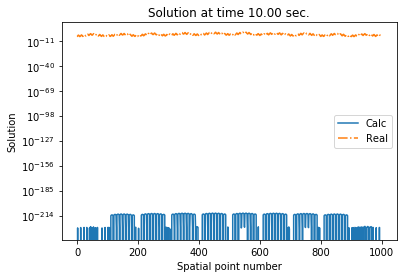

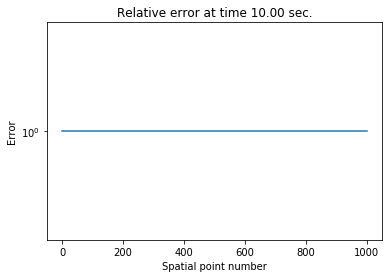

In [11]:
r_calc = r = SL.IT.calc(SL.X_hst)
r_real = SL.func_rs(SL.X_hst)
e = np.abs((r_calc - r_real) / r_real)
x = np.arange(r_calc.size)
I = r_real > 1.E-24
plt.plot(x[I], r_calc[I], label='Calc')
plt.plot(x[I], r_real[I], '-.', label='Real')
plt.semilogy()
plt.title('Solution at time %-4.2f sec.'%SL.t)
plt.xlabel('Spatial point number')
plt.ylabel('Solution')
plt.legend(loc='best')
plt.show()

plt.plot(x[I], e[I])
plt.semilogy()
plt.title('Relative error at time %-4.2f sec.'%SL.t)
plt.xlabel('Spatial point number')
plt.ylabel('Error')
plt.show()

<div class="head1">
    <div class="head1__name">
        Explicit solution
    </div>
    <div class="head1__note">
        Only for example.
    </div>
</div>

In [ ]:
import time
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from scipy.linalg import expm as expm

from intertrain import Intertrain

In [ ]:
d = 3
m = t_poi
n = x_poi
l = (x_max - x_min) / x_poi
h = (t_max - t_min) / (t_poi - 1)
T = np.linspace(t_min, t_max, t_poi)

<div class="head2">
    <div class="head2__name">
        Euler solver and uniform spatial grid
    </div>
</div>

We can solve this 1D equation on the uniform spatial grid for the time $t > 0$ with step $h$ and uniform spatial grid with step $l$ using 2th order finite difference scheme

$$
    \frac{\partial \rho}{\partial t} = (D + \widehat{Q}) \rho,
$$
where
$$
    \widehat{Q} \rho = f Q \rho - \frac{\partial f}{\partial x} \rho,
$$

$$
    D = \frac{1}{l^2} tridiag \left( 1, -2, 1 \right),
    \quad
    Q = \frac{1}{2 l} tridiag \left( -1, 0, 1 \right).
$$

Let apply 1th order splitting method on the time step $(k+1)$
$$
    \frac{\partial v}{\partial t} = D v,
    \quad
    v_{k} = \rho_{k},
    \quad
    v_{k+1} = v = ?,
$$
$$
    \frac{\partial w}{\partial t} = \widehat{Q} w,
    \quad
    w_{k} = v,
    \quad
    w_{k+1} = \rho_{k+1} = ?,
$$
and solve both ODE by the 1th order Euler method.

In [ ]:
_time = time.time()

X = [np.linspace(x_min, x_max, x_poi).reshape(1, -1)[:, 1:-1] for _ in range(d)]
X = np.meshgrid(*X, indexing='ij')
X = np.array(X).reshape((d, -1), order='F')

I = np.eye(x_poi-2)
Q = sp.spdiags([ [-1.]*n, [1.]*n ], [-1,  1], n, n).tocsr() 
Q = (Q / 2 / l).toarray()[1:-1, 1:-1]
Q = np.kron(np.kron(Q, I), I) + np.kron(np.kron(I, Q), I) + np.kron(np.kron(I, I), Q)
D = sp.spdiags([ [1.]*n, [-2.]*n, [1.]*n ], [-1, 0, 1], n, n).tocsr() 
D = (D / l / l).toarray()[1:-1, 1:-1]
D = dc * D
D = np.kron(np.kron(D, I), I) + np.kron(np.kron(I, D), I) + np.kron(np.kron(I, I), D)

r = func_r0(X).reshape(-1, 1)
for t in T[1:]:
    F0 = np.diag(func_f0(X, t).reshape(-1))
    F1 = np.diag(func_f1(X, t).reshape(-1))
    print(X.shape)
    print(F0.shape)
    w0 = r
    w1 = w0 + h * D @ w0
    v0 = w1
    v1 = v0 - h * F0 @ Q @ v0 - h * F1 @ v0
    r = v1
    
_time = time.time() - _time

print('Number of spatial points : %8d'%x_poi)
print('Number of time points    : %8d'%t_poi)
#print('Error (relative norm)    : %-12.2e'%e)
print('Total time (sec)         : %-12.2e'%_time)
print(np.linalg.norm(r))

<div class="end"></div>